In [67]:
# Check PyTorch GPU access
import torch
torch.cuda.is_available(),torch.cuda.device_count()

(True, 1)

In [68]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.device(device)

device(type='cuda')

# PyTorch workflow

1. Prepare and load data sets
2. Build a deep learning model
3. Fitting the model to data (training)
4. Making predictions and evaluating the model (inference)
5. Saving and loading a model
6. Putting it all together

In [69]:
import torch
from torch import nn # contains building blocks of graphs (or for us, neural networks)
import matplotlib.pyplot as plt

torch.__version__

'2.1.1+cu121'

## Preparing and loading data

- Excel spreadsheet
- Images of any kind
- Videos
- Audio
- Text

We'll create some *known* data using **linear regression**.

In [70]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting data into sets
> probably the most important concept in ML

- Training set: Model learns from this data (~60-80% of total data). This is always used.
- Validation set: Model gets tuned on this data (~10-20% of total data). This is often but not always used.
- Testing set: The model gets evaluated on this data to test what it has learned (~10-20%). This is always used.

In [71]:
# crudely split out 80% of data into training split and rest (20%) into test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split],y[:train_split]
X_test, y_test = X[train_split:],y[train_split:]

len(X_train),len(X_test),len(y_train),len(y_test)

(40, 10, 40, 10)

In [72]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
	"""
	Plots training data, test data and compares predictions
	"""
	plt.figure(figsize=(10,7))

	# plot training data in blue
	plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

	# Plot test data in green
	plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

	# Plot predictions if they exist
	if predictions is not None:
		plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

	plt.legend(prop={"size": 14})

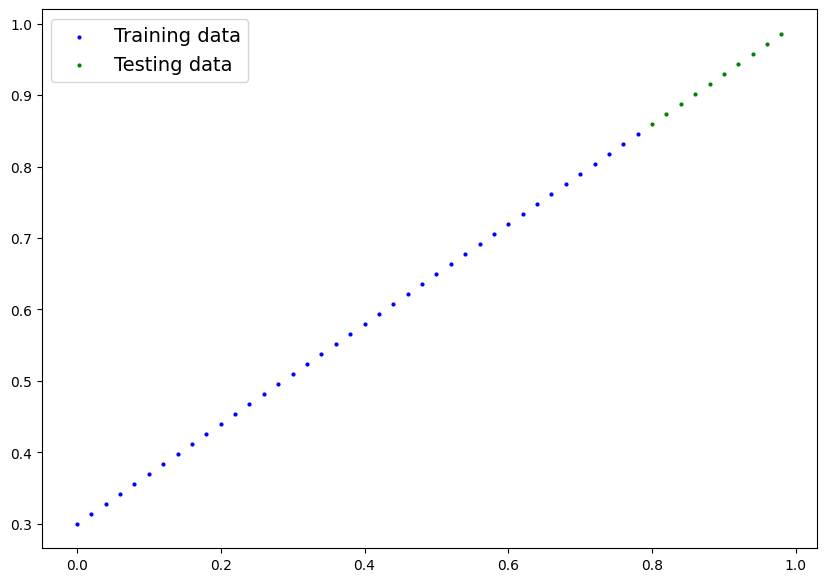

In [73]:
plot_predictions()

## Build a model

What our model does:
- Start with random values (weight & bias)
- Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data) we used to create the data.

How does it do so
- Gradient descent
- Backpropagation

In [74]:
# Create a linear regression model class
class LinearRegressionModel(nn.Module): # nn.Module is a base class for all neural network modules
	def __init__(self) -> None:
		super().__init__()
		self.weight = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
		self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

	# Forward method to define the computation in the model
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		return self.weight * x + self.bias # this is the linear regression formula

### PyTorch model building essentials

- `torch.nn` - contains all of the buildings for computational graphs (a neural network can be considered a computational graph).
- `torch.nn.Parameter` - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us.
- `torch.nn.Module` - The base class for all neural network modules, if you subclass is, you should implement forward().
- `torch.optim` - this is where the optimizers in PyTorch live, they will help with gradient descent.
- `def forward()` - Defines the forward computation

In [75]:
# Create a random seed
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [76]:
# List named parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

Module will call our `forward` method to make predictions

In [77]:
with torch.inference_mode():
	y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

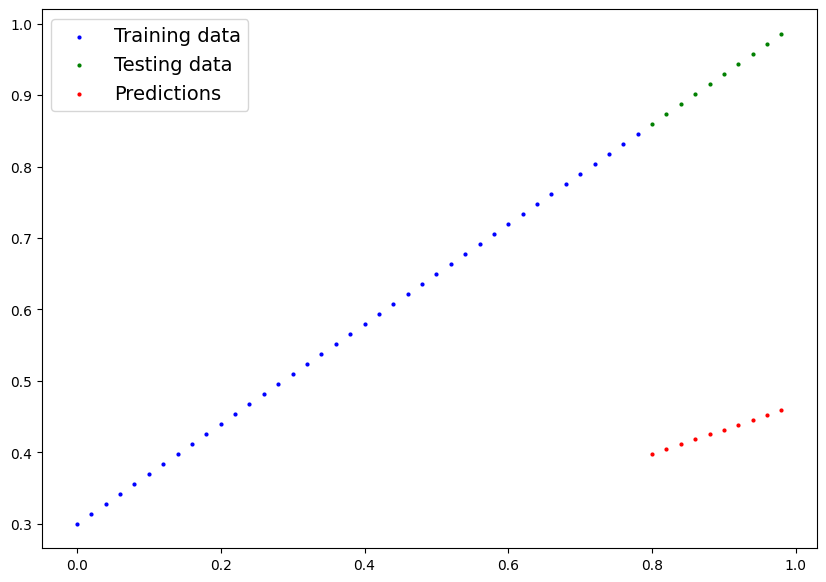

In [78]:
plot_predictions(predictions=y_preds)

Predictions were completely off! We need to train...

## Train model

Go from a poor representation of the data to a better representation of the data.

A **loss function** is a way to measure how distant your models predictions are from the desired predictions, which implies the lower the better.

An **optimizer** takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias), to improve the loss function.

Specifically for PyTorch, we need:
- A training loop
- A testing loop

In [79]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [80]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer - stochastic gradient descent
optimizer = torch.optim.SGD(
	params=model_0.parameters(), # the model parameters to optimize
	lr=0.01 # learning rate is a hyperparameter (some that an ML engineer sets) that defines how big/small the optimizer changes the parameters with each step
)

### Building a training loop in PyTorch

A training loop steps:

0. Loop through data
1. Forward pass: Involves data moving through our model's `forward()` function(s) to make predictions
2. Calculate the loss: Compare forward pass predictions to ground truth labels
3. Optimize zero grad
4. Loss backward (AKA backpropagation): Move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss
5. Optimizer step (AKA gradient descent)

In [ ]:
# track values in training to plot later
epoch_count = []
loss_values = []
test_loss_values = []

In [81]:
# An epoch (hyperparameter) is a loop through the data
epochs = 250

torch.manual_seed(42)

# step 0
for epoch in range(epochs):
	model_0.train() # sets all parameters in model to require gradients
	
	# step 1
	y_pred = model_0(X_train)

	# step 2
	loss = loss_fn(y_pred, y_train)

	# step 3
	optimizer.zero_grad()

	# step 4
	loss.backward()

	# step 5
	optimizer.step() # by default how the optimizer changes will accumulate through to loop... so we have to zero them above in step 3 for the next epoch
	
	### Testing
	model_0.eval() # turns off settings not required for eval/testing

	with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes
		# step 1
		test_pred = model_0(X_test)

		# step 2
		test_loss = loss_fn(test_pred, y_test)
	
	epoch_count.append(epoch)
	loss_values.append(loss)
	test_loss_values.append(test_loss)

	print(f"[{epoch}] State: {model_0.state_dict()}, Loss: {loss}, Test loss: {test_loss}")

[0] State: OrderedDict([('weight', tensor([0.3406])), ('bias', tensor([0.1388]))]), Loss: 0.31288138031959534, Test loss: 0.48106518387794495
[1] State: OrderedDict([('weight', tensor([0.3445])), ('bias', tensor([0.1488]))]), Loss: 0.3013603389263153, Test loss: 0.4675942063331604
[2] State: OrderedDict([('weight', tensor([0.3484])), ('bias', tensor([0.1588]))]), Loss: 0.28983935713768005, Test loss: 0.4541231691837311
[3] State: OrderedDict([('weight', tensor([0.3523])), ('bias', tensor([0.1688]))]), Loss: 0.2783183455467224, Test loss: 0.44065219163894653
[4] State: OrderedDict([('weight', tensor([0.3562])), ('bias', tensor([0.1788]))]), Loss: 0.26679736375808716, Test loss: 0.4271811842918396
[5] State: OrderedDict([('weight', tensor([0.3601])), ('bias', tensor([0.1888]))]), Loss: 0.2552763521671295, Test loss: 0.41371020674705505
[6] State: OrderedDict([('weight', tensor([0.3640])), ('bias', tensor([0.1988]))]), Loss: 0.24375534057617188, Test loss: 0.40023916959762573
[7] State: O

In [82]:
with torch.inference_mode():
	y_preds_new = model_0(X_test)

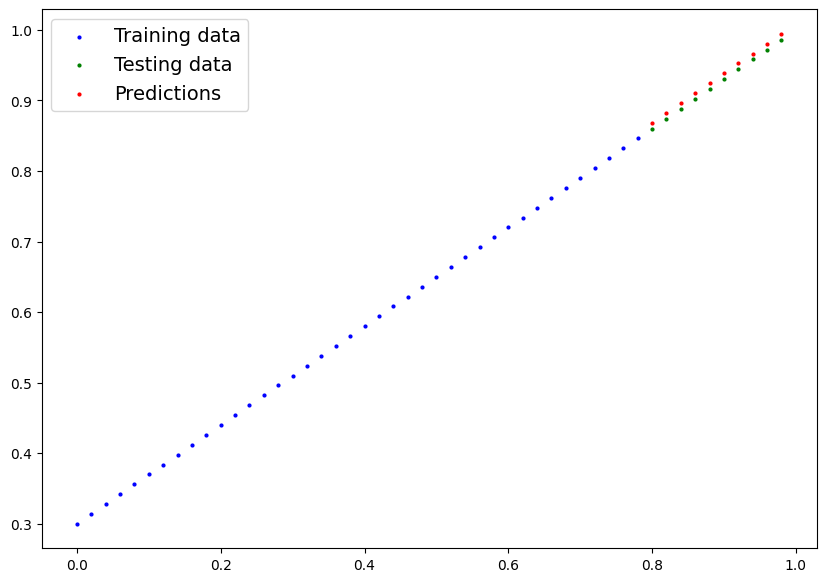

In [83]:
plot_predictions(predictions=y_preds_new)

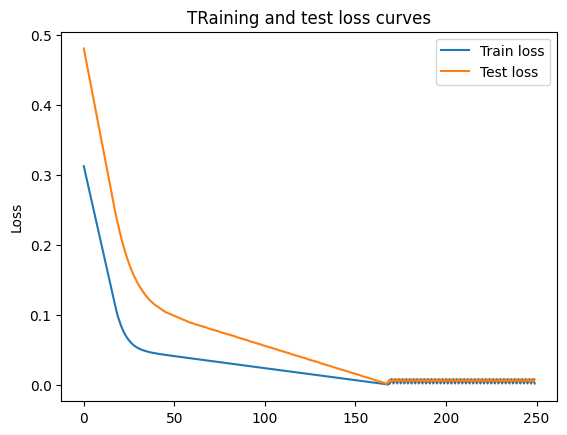

In [86]:
import numpy as np

# plot loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test loss")
plt.title("TRaining and test loss curves")
plt.ylabel("Loss")
plt.legend()



## Saving/Loading models in PyTorch

1. `torch.save()`: Save a pytorch object in python's pickle format
2. `torch.load()`: Allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()`: Allows to load a model's saved state dictionary (`.state_dict()`)

In [88]:
# save
from pathlib import Path

MODEL_DIR = Path("models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

MODEL_NAME="pytorch_workflow.pth"
MODEL_SAVE_PATH=MODEL_DIR/MODEL_NAME

torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

In [92]:
# load
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(state_dict=torch.load(MODEL_SAVE_PATH))
loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])